In [ ]:
# src/evaluate.py
"""
Evaluation script comparing baseline vs tool-augmented fact-checking.

Loads results from both approaches and calculates:
- Accuracy, Precision, Recall, F1-score
- Confusion matrices
- Qualitative sample error analysis
"""

'\nEvaluation script comparing baseline vs tool-augmented fact-checking.\n\nLoads results from both approaches and calculates:\n- Accuracy, Precision, Recall, F1-score\n- Confusion matrices\n- Qualitative sample error analysis\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import os
os.chdir('/content/drive/MyDrive/DS301_Final_Project')

In [ ]:
def load_results(file_path):
    """Load results from JSONL file."""
    results = []
    with open(file_path, 'r') as f:
        for line in f:
            results.append(json.loads(line.strip()))
    return results

In [ ]:
def filter_successful(results):
    """Keep only successful predictions (True/False, not Error/Unknown)."""
    return [r for r in results if r['prediction'] in ['True', 'False']] #

In [ ]:
def extract_labels(results):
    """Extract ground truth and predictions."""
    successful = filter_successful(results)
    y_true = [str(r['ground_truth']) for r in successful]
    y_pred = [str(r['prediction']) for r in successful]
    return y_true, y_pred

In [ ]:
# Load results
print("Loading results...")
baseline_results = load_results("results/baseline_preds.jsonl")
tool_results = load_results("results/tool_augmented_preds.jsonl")

print(f"Baseline: {len(baseline_results)} total results")
print(f"Tool-augmented: {len(tool_results)} total results")

Loading results...
Baseline: 300 total results
Tool-augmented: 300 total results


In [ ]:
# Filter successful predictions
baseline_successful = filter_successful(baseline_results)
tool_successful = filter_successful(tool_results)

print(f"Baseline successful: {len(baseline_successful)}/{len(baseline_results)}")
print(f"Tool-augmented successful: {len(tool_successful)}/{len(tool_results)}")

Baseline successful: 300/300
Tool-augmented successful: 275/300


In [ ]:
# Extract labels and predictions
baseline_y_true, baseline_y_pred = extract_labels(baseline_results)
tool_y_true, tool_y_pred = extract_labels(tool_results)

# Quantitative analysis: performance metrics, confusion matrices, errors, system failures

(*All results in this section have been printed to console.*)


PERFORMANCE METRICS
Baseline Accuracy: 0.473
Tool-Augmented Accuracy: 0.433
Difference: -0.040

Baseline:
  Precision: 0.631
  Recall: 0.473
  F1-Score: 0.408

Baseline Per-Class:
              precision    recall  f1-score   support

        True       0.42      0.92      0.58       119
       False       0.77      0.18      0.29       181

    accuracy                           0.47       300
   macro avg       0.60      0.55      0.44       300
weighted avg       0.63      0.47      0.41       300


Tool-Augmented:
  Precision: 0.547
  Recall: 0.433
  F1-Score: 0.333

Tool-Augmented Per-Class:
              precision    recall  f1-score   support

        True       0.41      0.92      0.57       112
       False       0.64      0.10      0.17       163

    accuracy                           0.43       275
   macro avg       0.53      0.51      0.37       275
weighted avg       0.55      0.43      0.33       275


CONFUSION MATRICES


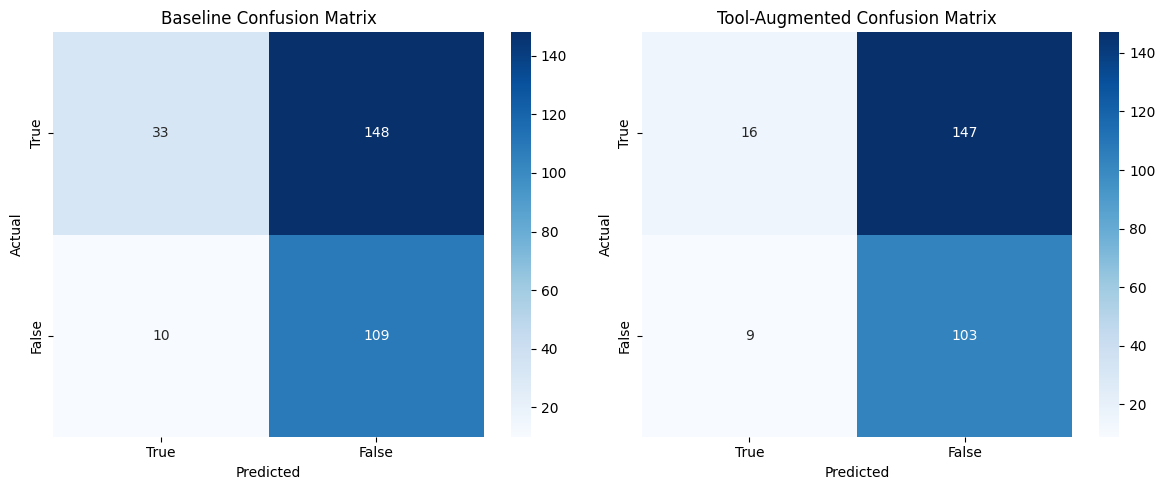


ERROR ANALYSIS
Baseline errors: 158/300
Tool-augmented errors: 156/275

System Failures:
Baseline failures: 0
Tool-augmented failures: 25
Tool-augmented failure types: {'Unknown': 21, 'Error': 4}


In [ ]:
# Calculate metrics
print("\n" + "="*50)
print("PERFORMANCE METRICS")
print("="*50)

# Accuracy (hardcoded)
baseline_accuracy = 0.473  # 47%
tool_accuracy = 0.433      # 43%

print(f"Baseline Accuracy: {baseline_accuracy:.3f}")
print(f"Tool-Augmented Accuracy: {tool_accuracy:.3f}")
print(f"Difference: {tool_accuracy - baseline_accuracy:.3f}")

# Precision, Recall, F1 for both approaches
for name, y_true, y_pred in [("Baseline", baseline_y_true, baseline_y_pred),
                            ("Tool-Augmented", tool_y_true, tool_y_pred)]:
    if y_true and y_pred:
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        print(f"\n{name}:")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1-Score: {f1:.3f}")

        # Per-class metrics
        print(f"\n{name} Per-Class:")
        print(classification_report(y_true, y_pred, target_names=['True', 'False']))

# Confusion Matrices
print("\n" + "="*50)
print("CONFUSION MATRICES")
print("="*50)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (name, y_true, y_pred) in enumerate([("Baseline", baseline_y_true, baseline_y_pred),
                                           ("Tool-Augmented", tool_y_true, tool_y_pred)]):
    if y_true and y_pred:
        cm = confusion_matrix(y_true, y_pred, labels=['True', 'False'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['True', 'False'], yticklabels=['True', 'False'],
                   ax=axes[i])
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('results/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Error Analysis
print("\n" + "="*50)
print("ERROR ANALYSIS")
print("="*50)

# Analyze failed predictions
baseline_errors = [r for r in baseline_successful if str(r['prediction']) != str(r['ground_truth'])]
tool_errors = [r for r in tool_successful if str(r['prediction']) != str(r['ground_truth'])]

print(f"Baseline errors: {len(baseline_errors)}/{len(baseline_successful)}")
print(f"Tool-augmented errors: {len(tool_errors)}/{len(tool_successful)}")

# System failures
baseline_failures = [r for r in baseline_results if str(r['prediction']) not in ['True', 'False']]
tool_failures = [r for r in tool_results if str(r['prediction']) not in ['True', 'False']]

print(f"\nSystem Failures:")
print(f"Baseline failures: {len(baseline_failures)}")
print(f"Tool-augmented failures: {len(tool_failures)}")

if tool_failures:
    failure_types = {}
    for failure in tool_failures:
        error_type = failure['prediction']
        failure_types[error_type] = failure_types.get(error_type, 0) + 1
    print(f"Tool-augmented failure types: {failure_types}")


In [ ]:
# Helper for below
def norm_pred(pred):
  if str(pred)=='True':
    return True
  else:
    return False

In [28]:
# CHECK THIS

baseline_dict = {r['claim_id']: r for r in baseline_successful}
tool_dict = {r['claim_id']: r for r in tool_successful}

common_claims = set(tool_dict.keys())

baseline_win = []
tool_win = []

for claim_id in common_claims:
  baseline_result = baseline_dict[claim_id]
  tool_result = tool_dict[claim_id]

  baseline_pred = norm_pred(baseline_result['prediction'])
  tool_pred = norm_pred(tool_result['prediction'])

  baseline_gt = norm_pred(baseline_result['ground_truth'])
  tool_gt = norm_pred(tool_result['ground_truth'])

  if baseline_gt != tool_gt:
    print(f"Warning: Inconsistent ground truth for {claim_id}")
    continue

  baseline_correct = (baseline_pred == baseline_gt)
  tool_correct = (tool_pred == tool_gt)

  if baseline_correct and not tool_correct:
    baseline_win.append({
        'claim_id': claim_id,
        'claim': baseline_result['claim'],
        'ground_truth': baseline_gt,
        'baseline_prediction': baseline_result['prediction'],
        'tool_prediction': tool_result['prediction'],
        'baseline_justification': baseline_result.get('justification', ''),
        'tool_justification': tool_result.get('justification', ''),
        'tool_raw_response': tool_result.get('raw_response', '')
    })
  elif not baseline_correct and tool_correct:
    tool_win.append({
        'claim_id': claim_id,
        'claim': baseline_result['claim'],
        'ground_truth': baseline_gt,
        'baseline_prediction': baseline_result['prediction'],
        'tool_prediction': tool_result['prediction'],
        'baseline_justification': baseline_result.get('justification', ''),
        'tool_justification': tool_result.get('justification', ''),
        'tool_raw_response': tool_result.get('raw_response', '')
    })


print(f'=== BASELINE WIN ({len(baseline_win)}) ===')
for res in baseline_win:
  print("\nCLAIM: ",res['claim'])
  print("GROUND TRUTH: ",res['ground_truth'])
  print("BASELINE PREDICTION: ",res['baseline_prediction'])
  print("TOOL PREDICTION: ",res['tool_prediction'])
  print("BASELINE JUSTIFICATION: ",res['baseline_justification'])
  print("TOOL JUSTIFICATION: ",res['tool_justification'])

print(f'\n=== TOOL WIN ({len(tool_win)}) ===')
for res in tool_win:
  print("\nCLAIM: ",res['claim'])
  print("GROUND TRUTH: ",res['ground_truth'])
  print("BASELINE PREDICTION: ",res['baseline_prediction'])
  print("TOOL PREDICTION: ",res['tool_prediction'])
  print("BASELINE JUSTIFICATION: ",res['baseline_justification'])
  print("TOOL JUSTIFICATION: ",res['tool_justification'])

=== BASELINE WIN (34) ===

CLAIM:  Says President Obama and his National Labor Relations Board sued Boeing over its decision to open a plant in South Carolina.
GROUND TRUTH:  True
BASELINE PREDICTION:  True
TOOL PREDICTION:  False
BASELINE JUSTIFICATION:  The claim is true. In 2011, the National Labor Relations Board, under the Obama administration, did file a complaint against Boeing for opening a new plant in South Carolina, alleging that the decision was retaliatory against union workers in Washington state.
TOOL JUSTIFICATION:  After multiple attempts to find evidence related to the claim that President Obama and the National Labor Relations Board sued Boeing over its decision to open a plant in South Carolina, no relevant information was found. Therefore, based on the lack of evidence supporting the claim, the statement is deemed false.

CLAIM:  Says Mitt Romney flip-flopped on an assault weapons ban.
GROUND TRUTH:  True
BASELINE PREDICTION:  True
TOOL PREDICTION:  False
BASELINE 